# 대용량 추천을 위한 컨텍스트 기반 텍스트 및 이미지 검색

제시된 솔루션은 텍스트 또는 이미지 쿼리를 기반으로 제품을 검색하고 추천하기 위한 Amazon Titan 다중 모드 임베딩 모델 기반 검색 엔진 프로토타입을 구축하는 구현 방법을 제공합니다. 이는 [Amazon Bedrock Titan 모델](https://aws.amazon.com/bedrock/titan)을 사용하여 이미지와 텍스트를 임베딩으로 인코딩하고, OpenSearch Service의 [k-최근접 이웃(KNN) 기능](https://docs.aws.amazon.com/opensearch-service/latest/developerguide/knn.html)을 사용하여 인덱스를 쿼리하는 단계별 가이드입니다.

# 1. 환경 설정

## Python Package 설치

In [1]:
# install_needed = True
install_needed = False

if install_needed:
    !pip install opensearch-py==2.5.0
    # !pip install requests-aws4auth
    !pip install -U boto3==1.34.87
    !pip install -U botocore==1.34.87
    !pip install -U awscli
    !pip install seaborn
    !pip install s3fs==2024.3.1 

In [2]:
! pip list | grep -E "boto|opensearch-py|s3fs"

aiobotocore                           2.7.0
boto3                                 1.34.87
botocore                              1.34.87
opensearch-py                         2.5.0
s3fs                                  2024.3.1


## 사용자 라이브러리 사용 경로 설정

In [3]:
%load_ext autoreload
%autoreload 2

import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = ".."
add_python_path(module_path)


python path: /home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/06_multi_modal_image_search is added
sys.path:  ['/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/06_multi_modal_image_search/notebook', '/opt/conda/lib/python310.zip', '/opt/conda/lib/python3.10', '/opt/conda/lib/python3.10/lib-dynload', '', '/opt/conda/lib/python3.10/site-packages', '/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/06_multi_modal_image_search']


## Bedrock Boto3 Client 생성

In [4]:
import boto3
import pandas as pd
import os
import re
import boto3
import json
import time
import base64
import logging
import numpy as np
import seaborn as sns
from PIL import Image
from io import BytesIO


from tqdm import tqdm
from urllib.parse import urlparse
# from multiprocessing.pool import ThreadPool

# from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth, helpers

In [5]:
# getting boto3 clients for required AWS services
sts_client = boto3.client('sts')
s3_client = boto3.client('s3')
# aoss_client = boto3.client('opensearchserverless')

bedrock_client = boto3.client(
    "bedrock-runtime", 
    "us-east-1", 
    endpoint_url="https://bedrock-runtime.us-east-1.amazonaws.com"
)

In [6]:
session = boto3.session.Session()
region_name = session.region_name
account_id = sts_client.get_caller_identity()["Account"]
region_name, account_id

('us-east-1', '057716757052')

# 2. 이미 저장된 JSON 파일에서 데이터 로딩

In [14]:
from search_utils.utils import (
                        save_dataset_to_json,
                        load_json_pandas_dataset,
                        plot_similarity_heatmap,
)

save_path = "../data/berkely/berkely_image_embedding.json"

# save_dataset_to_json(save_path, dataset)    
loaded_json_berkely = load_json_pandas_dataset(save_path)
loaded_json_berkely.tail(2)



sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


,item_id,item_name_in_en_us,main_image_id,image_id,height,width,path,img_full_path,embedding_img
1647,B07JQX8S2X,Amazon Basics Tufted Outdoor Square Seat Patio...,91XM523rZgL,91XM523rZgL,2560,2560,45/45e8e821.jpg,s3://amazon-berkeley-objects/images/small/45/4...,"[-0.052831195000000004, -0.016111642000000002,..."
1648,B074MG76KH,"365 Everyday Value, Daily Shower Cleaner, 32 f...",71c2Ny+WfoL,71c2Ny+WfoL,2560,1143,9f/9fefdb9d.jpg,s3://amazon-berkeley-objects/images/small/9f/9...,"[-0.047227167, 0.013820353, 0.009427128, -0.07..."


# 3. OpenSearch Index 에 데이터 저장

## OpenSearch 연결 세팅

In [15]:
from search_utils.proc_docs import get_parameter

In [16]:
import boto3
ssm = boto3.client('ssm', 'us-east-1')

opensearch_domain_endpoint = get_parameter(
    boto3_clinet = ssm,
    parameter_name = 'opensearch_domain_endpoint',
)

opensearch_user_id = get_parameter(
    boto3_clinet = ssm,
    parameter_name = 'opensearch_user_id',
)

opensearch_user_password = get_parameter(
    boto3_clinet = ssm,
    parameter_name = 'opensearch_user_password',
)


In [17]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

## 인덱스 이름 정의

In [18]:
index_name = f"v1_large_scale_multi_model_search"

## 인덱스 정의

In [19]:
index_body = {
   "settings": {
      "index.knn": "true"
   },
   "mappings": {
      "properties": {
         "image_vector": {
            "type": "knn_vector",
            "dimension": 1024 # Embedding size for Amanon Titan Multimodal Embedding G1 model, it is 1,024 (default), 384, 256
         },
         "description": {"type": "text"},
          "item_id" : {"type": "text"},
         "image_url": {"type": "text"}
      }
   }
}


## OpenSearch Client 생성

In [20]:
from search_utils.opensearch import opensearch_utils

In [21]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)

os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

## 정의된 인덱스 없으면 생성

In [22]:
index_exists = opensearch_utils.check_if_index_exists(
    os_client,
    index_name
)

if index_exists:
    # opensearch_utils.delete_index(
    #     os_client,
    #     index_name
    # )
    pass
else:
    print(f"{index_name} does not exist")
    # We would get an index already exists exception if the index already exists, and that is fine.
    try:
        opensearch_utils.create_index(os_client, index_name,index_body)
        print(f"response received for the create index -> {response}")
    except Exception as e:
        print(f"error in creating index={index_name}, exception={e}")



index_name=v1_large_scale_multi_model_search, exists=True


## 인덱스에 데이터 저장

다음으로 데이터셋을 반복하며 항목 데이터를 클러스터에 ingesting해야 합니다. 임베딩 ingestion에 대한 더 강력하고 확장 가능한 솔루션은 [Ingesting enriched data into Amazon ES](https://aws.amazon.com/blogs/industries/novartis-ag-uses-amazon-elasticsearch-k-nearest-neighbor-knn-and-amazon-sagemaker-to-power-search-and-recommendation/)에서 찾을 수 있습니다. 이 POC를 위한 데이터 ingestion은 60초 이내에 완료되어야 합니다. 또한 간단한 쿼리를 실행하여 데이터가 인덱스에 ingesting되었는지 확인합니다.

In [24]:
%%time
import tqdm.notebook as tq

def add_doc_to_opensearch(os_client, index_name, dataset):

    for idx, record in tq.tqdm(dataset.iterrows(), total=len(dataset)):
        image_vector = dataset['embedding_img'][idx]
        description = dataset['item_name_in_en_us'][idx]
        item_id = dataset['item_id'][idx]
        image_url = dataset['img_full_path'][idx]

        document = opensearch_utils.create_opensearch_doc(image_vector,description, item_id, image_url)   
        response = opensearch_utils.add_doc(os_client, index_name,document, verbose=False, id = None)               

add_doc_to_opensearch(os_client=os_client, index_name=index_name, dataset=loaded_json_berkely)        


  0%|          | 0/1649 [00:00<?, ?it/s]

CPU times: user 4.84 s, sys: 278 ms, total: 5.12 s
Wall time: 22.6 s


In [25]:
total_count_docs = opensearch_utils.get_count(os_client, index_name)
print("total count docs: ", total_count_docs)

total count docs:  {'count': 18139, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}


## 병렬로 문서 삽입 하기
- num_dataset: 저장할 데이타 세트 개수
    - 10 이면 1649 * 10 = 16,490 이 저장
- num_worker: 실행할 Thread 수
    - 5 이면 1개의 Thread 가 2 개의 dataset 을 저장함.    

In [49]:
opensearch_utils.parallel_add_doc_to_opensearch(os_client=os_client, 
                                                num_dataset=10, 
                                                num_worker=5, 
                                                index_name=index_name, 
                                                dataset=loaded_json_berkely)                    

        

  0%|          | 0/1649 [00:00<?, ?it/s]

  0%|          | 0/1649 [00:00<?, ?it/s]

  0%|          | 0/1649 [00:00<?, ?it/s]

  0%|          | 0/1649 [00:00<?, ?it/s]

  0%|          | 0/1649 [00:00<?, ?it/s]

get_result:  {'count': 87387, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}
get_result:  {'count': 87387, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}
get_result:  {'count': 87387, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}
get_result:  {'count': 87387, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}
get_result:  {'count': 87387, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}


  0%|          | 0/1649 [00:00<?, ?it/s]

  0%|          | 0/1649 [00:00<?, ?it/s]

  0%|          | 0/1649 [00:00<?, ?it/s]

  0%|          | 0/1649 [00:00<?, ?it/s]

  0%|          | 0/1649 [00:00<?, ?it/s]

get_result:  {'count': 95640, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}
get_result:  {'count': 95640, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}
get_result:  {'count': 95640, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}
get_result:  {'count': 95640, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}
get_result:  {'count': 95640, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}


# 5. 실시간 다중 모드 검색 수행

이제 재고품의 임베딩을 포함하는 작동 중인 OpenSearch 인덱스가 있으므로 새 항목에 대한 임베딩을 생성하는 방법을 살펴보겠습니다. Amazon Titan 다중 모드 임베딩 G1 1세대(G1)를 사용하여 텍스트 및 이미지 특징을 추출할 것입니다.

간단한 쿼리의 결과를 살펴보겠습니다. OpenSearch 서비스에서 결과를 검색한 후 데이터셋에서 항목 이름과 이미지를 가져옵니다.

## 5.1. 텍스트 입력 기반으로 이미지 검색 수행

In [50]:
from search_utils.utils import (
            get_image_from_item_id_s3,
            get_titan_multimodal_embedding,
            find_similar_items_from_query,
            find_similar_items_from_image,
            display_images,
)

간단한 쿼리의 결과를 살펴보겠습니다. 아래 예시에서는 사용자로부터 "drinkware glass"와 같은 텍스트 입력을 받고, 이를 검색 엔진에 보내 유사한 항목을 찾을 것입니다.

In [51]:
query_prompt = "drinkware glass"

번역: 사용자 쿼리를 기반으로 유사한 항목을 찾습니다. 입력 쿼리를 바탕으로 우리 데이터셋에서 유리 드링크웨어를 찾은 것을 확인할 수 있습니다. 이것이 우리가 달성하고자 하는 목표입니다.

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


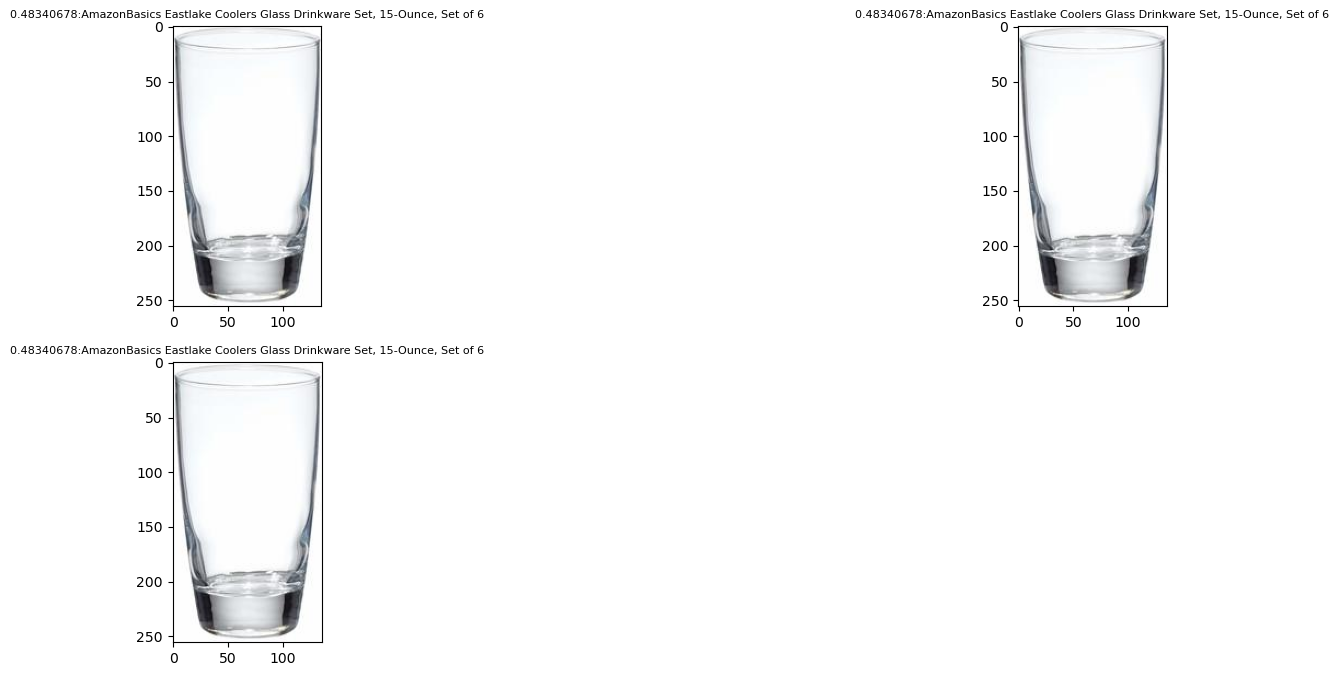

In [52]:
similar_items = find_similar_items_from_query(query_prompt = query_prompt, k=5, num_results=3, index_name=index_name, 
                                    dataset = loaded_json_berkely, 
                                    open_search_client = os_client, image_root_path=f's3://amazon-berkeley-objects/images/small/')

display_images(similar_items)

## 5.2 이미지 입력 기반으로 이미지 검색 수행

간단한 이미지를 기반으로 결과를 살펴보겠습니다. 입력 이미지는 벡터 임베딩으로 변환되고, 유사성 검색을 기반으로 결과가 반환될 것입니다.

어떤 이미지든 사용할 수 있지만, 아래 예시에서는 위 데이터셋에서 item_id(예: item_id = "B07JCDQWM6")를 기반으로 무작위 이미지를 선택하고, 이 이미지를 검색 엔진에 보내 유사한 항목을 찾을 것입니다. 먼저 item_id를 기반으로 이미지와 이미지 위치를 가져오겠습니다.

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Amazon Brand – Rivet Thomas Modern Leather Sofa Couch, 81.5"W, Chestnut


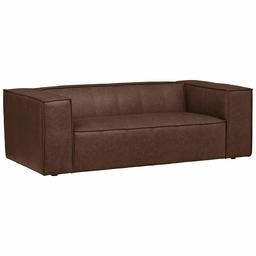

In [53]:
item_id = "B07JCDQWM6"

image, item_name = get_image_from_item_id_s3(item_id = item_id, dataset = loaded_json_berkely, image_path = f's3://amazon-berkeley-objects/images/small/' )
print(item_name)
image

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


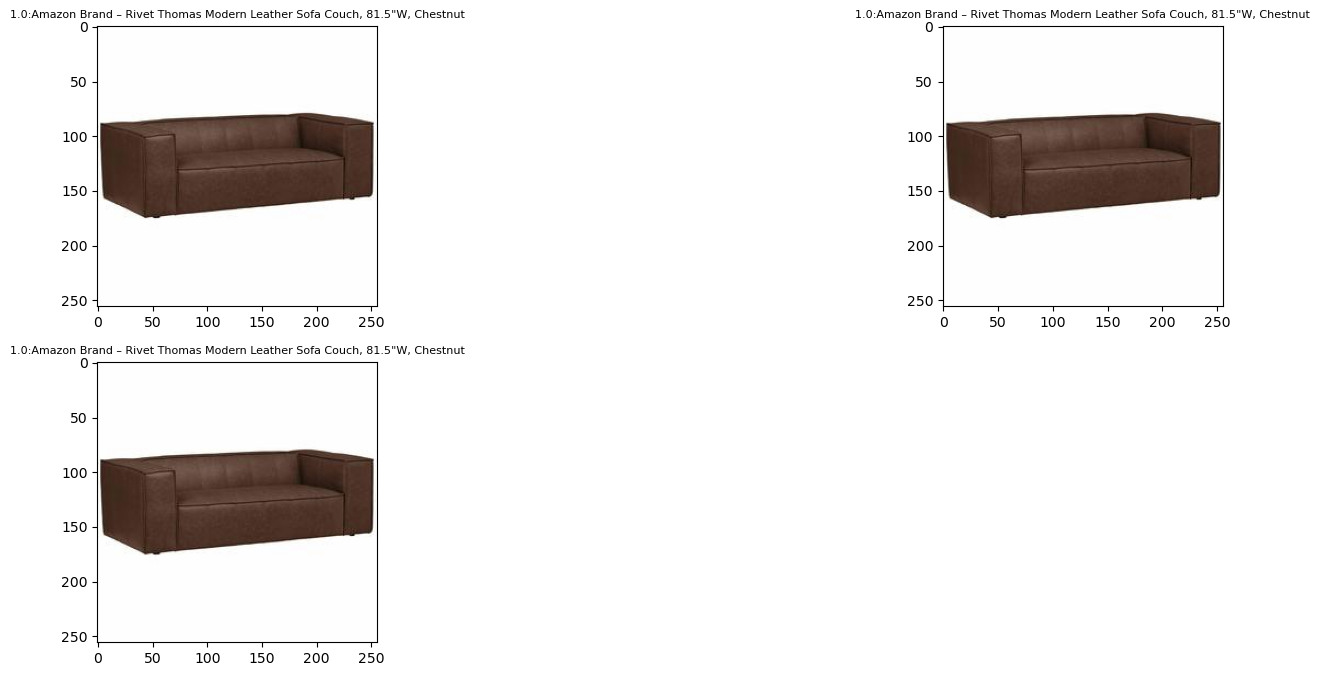

In [54]:
item_id = "B07JCDQWM6"
dataset = loaded_json_berkely
search_image_path = dataset[dataset['item_id']==item_id]['img_full_path'].iloc[0]

similar_items = find_similar_items_from_image(image_path = search_image_path, k=5, num_results=3, index_name=index_name, dataset = dataset, 
                                   open_search_client = os_client, image_root_path=f's3://amazon-berkeley-objects/images/small/')

display_images(similar_items)

## 6. Clean up

인덱스를 삭제를 위해서는 아래 코드의 주석을 제거하고 실행 하세요.
오픈 서치 도메인을 삭제 하기 위해서는, 오픈 서치 콘솔에 로그인해서 지우시기 바립니다.

In [34]:
# delete vector index

# if index_exists:
#     opensearch_utils.delete_index(
#         os_client,
#         index_name
#     )
# else:
#     print(f"{index_name} does not exist")


